In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import njit, prange
from scipy.sparse import csc_matrix, linalg as sla
from scipy.optimize import root
from scipy.special import erfc

/home/IPP-HGW/patricks/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
R1 = 0.2
R2 = 8
r = np.linspace(R1, R2, 100)
lr = len(r)
dr = (np.max(r)-np.min(r))/(lr-1)

In [4]:
@njit
def dF_dr(r, dr, lr, n0):
    df_dr = np.zeros((lr, lr, lr))
    v_para = np.linspace(0, 10, lr)
    v_perp = np.linspace(0, 10, lr)

    for i in range(lr-1):
        dn_dr = (r[i]-dr/2)*(n0[i+1]-n0[i])/dr
        n = (n0[i+1]+n0[i])/2
        for j in range(lr):
            for k in range(lr):
                df_dr[i, j, k] = np.exp(-v_para[j]**2-v_perp[k]**2)*(dn_dr - n*(v_para[j]**2+v_perp[k]**2/2))
    return(df_dr)

In [68]:
@njit(parallel=True)
def InF(v_max, lr, a):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    inf = np.zeros(len(a))

    for i in prange(len(a)):
        bra = a[i]*(v_para[0]**2+v_perp[0]/2)
        f = np.exp(-v_para[0]**2/2-v_perp[0]/2)/(1+bra)
        inf_dperp0 = 0
        for l in range(1, lr):
            dperp = (v_perp[l]-v_perp[l-1])
            bra = a[i]*(v_para[0]**2+v_perp[l]/2)
            f0 = f
            f = np.exp(-v_para[0]**2/2-v_perp[l]/2)/(1+bra)
            inf_dperp0 = inf_dperp0 + dperp*(f+f0)/2
        for j in range(1, lr):
            bra = a[i]*(v_para[j]**2+v_perp[0]/2)
            f = np.exp(-v_para[j]**2/2-v_perp[0]/2)/(1+bra)
            inf_dperp = 0
            for k in range(1, lr):
                dperp = (v_perp[k]-v_perp[k-1])
                bra = a[i]*(v_para[j]**2+v_perp[k]/2)
                f0 = f
                f = np.exp(-v_para[j]**2/2-v_perp[k]/2)/(1+bra)
                inf_dperp = inf_dperp + dperp*(f+f0)/2
            inf[i] = inf[i] + (v_para[j]-v_para[j-1])*(inf_dperp+inf_dperp0)/2
            inf_dperp0 = inf_dperp
            
    return inf

In [113]:
@njit(parallel=True)
def InF(v_max, lr, a):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    inf_r = np.zeros(len(a))
    inf_i = np.zeros(len(a))
    a_r = np.real(a)
    a_i = np.imag(a)

    for i in prange(len(a)):
        bra = v_para[0]**2+v_perp[0]/2
        den = (1+a_r[i]*bra)**2 + (a_i[i]*bra)**2
        exp = np.exp(-v_para[0]**2/2-v_perp[0]/2)
        f_r = (1+a_r[i]*bra)*exp/den
        f_i = -a_i[i]*bra*exp/den
        inf_dperp0_r = 0
        inf_dperp0_i = 0
        for l in range(1, lr):
            dperp = (v_perp[l]-v_perp[l-1])
            bra = v_para[0]**2+v_perp[l]/2
            den = (1+a_r[i]*bra)**2 + (a_i[i]*bra)**2
            exp = np.exp(-v_para[0]**2/2-v_perp[l]/2)
            f0_r = f_r
            f0_i = f_i
            f_r = (1+a_r[i]*bra)*exp/den
            f_i = -a_i[i]*bra*exp/den
            inf_dperp0_r = inf_dperp0_r + dperp*(f_r+f0_r)/2
            inf_dperp0_i = inf_dperp0_i + dperp*(f_i+f0_i)/2
        for j in range(1, lr):
            bra = v_para[j]**2+v_perp[0]/2
            den = (1+a_r[i]*bra)**2 + (a_i[i]*bra)**2
            exp = np.exp(-v_para[j]**2/2-v_perp[0]/2)
            f_r = (1+a_r[i]*bra)*exp/den
            f_i = -a_i[i]*bra*exp/den
            inf_dperp_r = 0
            inf_dperp_i = 0
            for k in range(1, lr):
                dperp = (v_perp[k]-v_perp[k-1])
                bra = v_para[j]**2+v_perp[k]/2
                den = (1+a_r[i]*bra)**2 + (a_i[i]*bra)**2
                exp = np.exp(-v_para[j]**2/2-v_perp[k]/2)
                f0_r = f_r
                f0_i = f_i
                f_r = (1+a_r[i]*bra)*exp/den
                f_i = -a_i[i]*bra*exp/den
                inf_dperp_r = inf_dperp_r + dperp*(f_r+f0_r)/2
                inf_dperp_i = inf_dperp_i + dperp*(f_i+f0_i)/2
            inf_r[i] = inf_r[i] + (v_para[j]-v_para[j-1])*(inf_dperp_r+inf_dperp0_r)/2
            inf_i[i] = inf_i[i] + (v_para[j]-v_para[j-1])*(inf_dperp_i+inf_dperp0_i)/2
            inf_dperp0_r = inf_dperp_r
            inf_dperp0_i = inf_dperp_i
            
    return inf_r, inf_i

In [126]:
a = np.linspace(0.01, 1, 500)
inf_r, inf_i = InF(5, 100, a)

0.0 0.31731050786291415


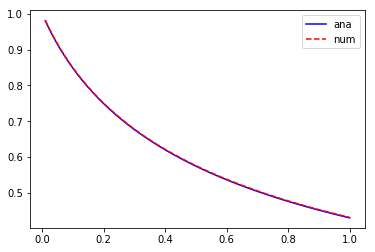

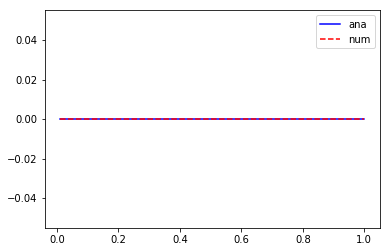

In [127]:
Erfc = erfc(1/np.sqrt(2*(a)))
print(np.max(np.imag(Erfc)),np.max(np.real(Erfc)))
a_r = np.real(a)
a_i = np.imag(a)
ana = np.pi*np.exp(1/a)*Erfc**2/(2*a)
plt.plot(np.real(a), np.real(ana), 'b', label="ana")
plt.plot(np.real(a), inf_r/np.sqrt(2*np.pi), 'r', label="num", linestyle="dashed")
plt.legend()
plt.show()

plt.plot(np.real(a), np.imag(ana), 'b', label="ana")
plt.plot(np.real(a), inf_i/np.sqrt(2*np.pi), 'r', label="num", linestyle="dashed")
plt.legend()
plt.show()

In [4]:
@njit(parallel = True)
def InF(r, dr, lr, df_dr, omega, in0, a_para, a_perp):
    v_para = np.linspace(0, 10, lr)
    v_perp = np.linspace(0, 10, lr)
    inf_dperp = 0
    inf_r = np.zeros(lr)
    inf_i = np.zeros(lr)
    for i in prange(lr-1):
        for j in range(lr-1):
            f_r = 0
            f_i = 0
            for k in range(lr-1):
                dperp = v_perp[k+1]**2-v_perp[k]**2
                bra = (a_para*v_para[j]**2+a_perp*v_perp[k]**2/2)
                f0_r = f_r
                f0_i = f_i
                f_r = df_dr[i, j, k]*(omega[0]-in0[i]-bra)/((omega[0]-in0[i]-bra)**2 + omega[1]**2)
                f_i = df_dr[i, j, k]*(omega[1])/((omega[0]-in0[i]+bra)**2 + omega[1]**2)
                inf_dperp_r = inf_dperp_r + (f0_r+f_r)*dperp
                inf_dperp_i = inf_dperp_i + (f0_i+f_i)*dperp
            inf_r[i] = inf_r[i] + (v_perp[j+1]-v_perp[j])*inf_dperp_r
            inf_i[i] = inf_i[i] + (v_perp[j+1]-v_perp[j])*inf_dperp_i
    return inf_r, inf_i

In [117]:
#Poisson Solver
@njit(parallel=True)
def M(r, dr):
    col = np.zeros(3*len(r)-4)
    row = np.zeros(3*len(r)-4)
    data = np.zeros(3*len(r)-4)
    data[0] = 1
    for i in prange(1, len(r)-1):
        row[3*i-1:3*i+2] = i
        col[3*i-1] = i-1
        col[3*i] = i
        col[3*i+1] = i+1
        data[3*i-1] = (r[i]-dr/2)/(dr**2*r[i])
        data[3*i] = -2/dr**2
        data[3*i+1] = (r[i]+dr/2)/(dr**2*r[i])
    row[-1] = len(r)-1
    col[-1] = len(r)-1
    data[-1] = len(r)-1
    return data, col, row

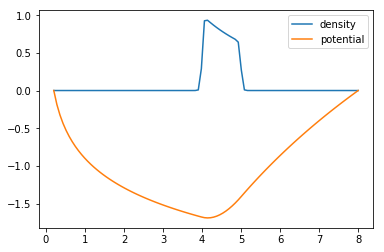

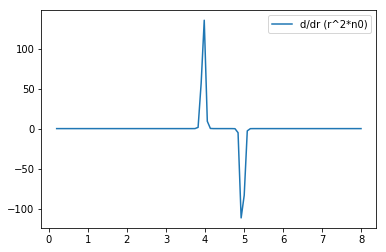

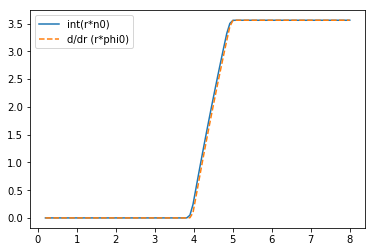

In [125]:
data, col, row = M(r, dr)
A = csc_matrix((data, (row, col)), shape=(len(r), len(r)))
lu = sla.splu(A)

n0 = (8/r**2)*(np.tanh(25*(r-4))-np.tanh(25*(r-5)))
phi = lu.solve(n0)

plt.plot(r, n0, label='density')
plt.plot(r, phi, label='potential')
plt.legend()
plt.show()

dn0 = np.zeros(len(r))
dn0_hot = np.zeros(len(r))
in0 = np.zeros(len(r))
dphi = np.zeros(len(r))

dn0[0] = (r[1]**2*n0[1] - r[0]**2*n0[0])/dr
dn0_hot[0] = (r[1]+r[0])*(n0[1] - n0[0])/(2*dr)
in0[0] = dr*(r[1]*n0[1] + r[0]*n0[0])/2
dphi[0] = (r[0]+dr/2)*(phi[1]-phi[0])/dr
for i in range(len(r)-1):
    dn0[i] = (r[i+1]**2*n0[i+1] - r[i]**2*n0[i])/dr
    dn0_hot[i] = (r[i+1]+r[i])*(n0[i+1] - n0[i])/(2*dr)
    in0[i] = in0[i-1] + dr*(r[i+1]*n0[i+1] + r[i]*n0[i])/2
    dphi[i] = (r[i]+dr/2)*(phi[i+1]-phi[i])/dr
dn0[-1] = 2*dn0[-2] - dn0[-3]
dn0_hot[-1] = 2*dn0_hot[-2] - dn0_hot[-3]
in0[-1] = 2*in0[-2] - in0[-3]
dphi[-1] = 2*dphi[-2] - dphi[-3]
dphi = dphi - dphi[0]

plt.plot(r, dn0, label='d/dr (r^2*n0)')
plt.legend()
plt.show()

plt.plot(r, in0, label='int(r*n0)')
plt.plot(r, dphi, label='d/dr (r*phi0)', linestyle='dashed')
plt.legend()
plt.show()

In [119]:
def shooting(r, dr, dn0, in0, omega):
    @njit(parallel = True)
    def fun(omega):

        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = ((r[i]-dr/2)/(dr**2*r[i]))
            drm = -2/dr**2
            drr = -((dr**2*r[i])/(r[i]+dr/2))
            diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
            diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

In [146]:
def hot_shooting(r, dr, n0, dn0, in0, kl, omega):
    @njit(parallel = True)
    def fun(omega):

        a = kl/(-omega[0]-omega[1]*1j+in0)
        inf_r, inf_i = InF(5, 100, a)
        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = ((r[i]-dr/2)/(dr**2*r[i]))
            drm = -2/dr**2
            drr = -((dr**2*r[i])/(r[i]+dr/2))
            den = r[i]*((omega[0]-in0[i])**2 + omega[1]**2)
            diag_real = (inf_r[i]*(dn0[i]*(omega[0]-in0[i])-n0[i]/kl) + inf_i[i]*(dn0_hot[i]*omega[1]))/den + n0[i]/kl
            diag_imag = (inf_r[i]*(dn0[i]*omega[1]) + inf_i[i]*(dn0_hot[i]*omega[1]))/den

            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

    fjac: array([[ 0.76095318, -0.64880679],
       [ 0.64880679,  0.76095318]])
     fun: array([-1.37319867e-10,  2.33491285e-10])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([ 1.03746022e-06, -2.13115153e-07])
       r: array([1.47841537e+03, 3.19320202e-01, 1.47867471e+03])
  status: 1
 success: True
       x: array([2.0677951 , 0.66859582])
[1.03389755 0.33429791]


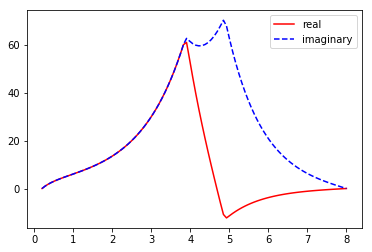

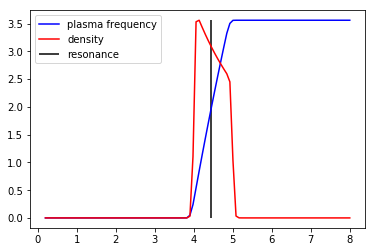

In [136]:
bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x

phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = ((r[i]-dr/2)/(dr**2*r[i]))
    drm = -2/dr**2
    drr = -((dr**2*r[i])/(r[i]+dr/2))
    diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
    diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

    fjac: array([[ 0.76095318, -0.64880679],
       [ 0.64880679,  0.76095318]])
     fun: array([-1.37319867e-10,  2.33491285e-10])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([ 1.03746022e-06, -2.13115153e-07])
       r: array([1.47841537e+03, 3.19320202e-01, 1.47867471e+03])
  status: 1
 success: True
       x: array([2.0677951 , 0.66859582])


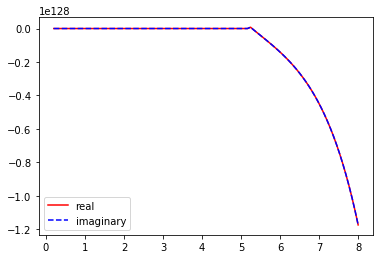

In [145]:
bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x
kl = 1e-10
om = (omega[0]+omega[1]*1j)*2
a = kl/(-om+in0)
inf_r, inf_i = InF(5, 100, a)
phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = ((r[i]-dr/2)/(dr**2*r[i]))
    drm = -2/dr**2
    drr = -((dr**2*r[i])/(r[i]+dr/2))
    den = r[i]*((omega[0]-in0[i])**2 + omega[1]**2)
    diag_real = (inf_r[i]*(dn0_hot[i]*(omega[0]-in0[i])-n0[i]/kl) + inf_i[i]*(dn0_hot[i]*omega[1]))/den + n0[i]/kl
    diag_imag = (inf_r[i]*(dn0_hot[i]*omega[1]) + inf_i[i]*(dn0_hot[i]*omega[1]))/den

    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)
    
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

    fjac: array([[-0.70047962,  0.71367241],
       [-0.71367241, -0.70047962]])
     fun: array([1.33677751e+33, 1.31213284e+33])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 99
     qtf: array([ 2.14397071e+30, -1.87316431e+33])
       r: array([ 9.37959097e+38, -3.27711332e+38, -1.93584292e+34])
  status: 5
 success: False
       x: array([1.0010214 , 0.25509037])
[0.5005107  0.12754518]


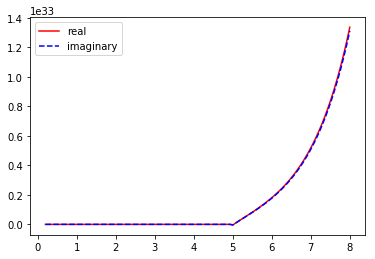

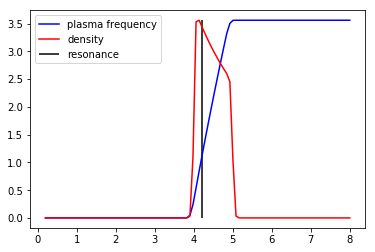

In [149]:
kl = 1e-5

bullet = hot_shooting(r, dr, n0, dn0_hot, in0, kl, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x

a = kl/(-omega[0]-omega[1]*1j+in0)
inf_r, inf_i = InF(5, 100, a)
phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = ((r[i]-dr/2)/(dr**2*r[i]))
    drm = -2/dr**2
    drr = -((dr**2*r[i])/(r[i]+dr/2))
    den = r[i]*((omega[0]-in0[i])**2 + omega[1]**2)
    diag_real = (inf_r[i]*(dn0_hot[i]*(omega[0]-in0[i])-n0[i]/kl) + inf_i[i]*(dn0_hot[i]*omega[1]))/den + n0[i]/kl
    diag_imag = (inf_r[i]*(dn0_hot[i]*omega[1]) + inf_i[i]*(dn0_hot[i]*omega[1]))/den

    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

In [41]:
@njit(parallel=True)
def density_stuff(r, dr, n0):
    dn0 = np.zeros(len(r))
    in0 = np.zeros(len(r))

    for i in range(len(r)-1):
        dn0[i] = (r[i+1]**2*n0[i+1] - r[i]**2*n0[i])/dr
        in0[i] = in0[i-1] + dr*(r[i+1]*n0[i+1] + r[i]*n0[i])/2
    dn0[-1] = 2*dn0[-2] - dn0[-3]
    in0[-1] = 2*in0[-2] - in0[-3]
    return dn0, in0

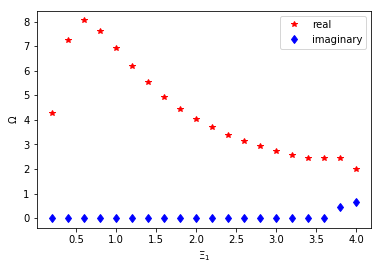

In [42]:

r1 = np.linspace(0.2, 4, 20)
omega_r = np.empty(len(r1))
omega_i = np.empty(len(r1))
for i in range(len(r1)):
    n0 = (8/r**2)*(np.tanh(25*(r-r1[i]))-np.tanh(25*(r-5)))
    dn0, in0 = density_stuff(r, dr, n0)

    bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.1]))
    omega_r[i] = bullet.x[0]
    omega_i[i] = bullet.x[1]

plt.plot(r1, omega_r, "r*", label='real')
plt.plot(r1, omega_i, "bd", label='imaginary')
plt.ylabel("$\Omega$")
plt.xlabel("$\Xi_1$")
plt.legend()
plt.show()

    fjac: array([[-0.70706819,  0.70714537],
       [-0.70714537, -0.70706819]])
     fun: array([192987.93193028, 192987.43233853])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 16
     qtf: array([ 1.42029931e+01, -2.72925878e+05])
       r: array([-5.59703456e-01,  5.72156363e-02,  2.90998392e-04])
  status: 5
 success: False
       x: array([ 488.33340744, 3277.20779814])
[ 244.16670372 1638.60389907]


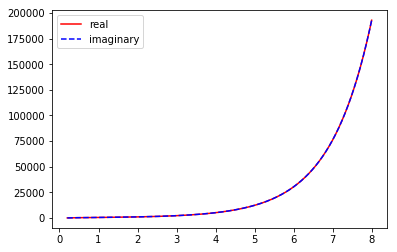

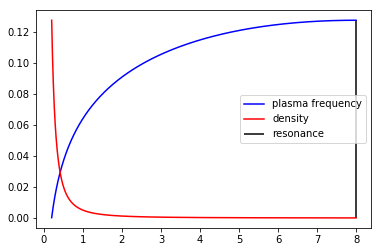

In [43]:
#n0 = (8/r**2)*(np.tanh(25*(r-0.2))-np.tanh(25*(r-5)))
n0 = (r**-2 - R2**-2)/R1**-2
dn0, in0 = density_stuff(r, dr, n0)

bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x

phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = ((r[i]-dr/2)/(dr**2*r[i]))
    drm = -2/dr**2
    drr = -((dr**2*r[i])/(r[i]+dr/2))
    diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
    diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

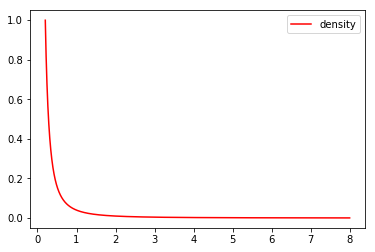

0.0


In [44]:
n0 = (r**-2 - R2**-2)/R1**-2

plt.plot(r, n0, "r", label='density')
plt.legend()
plt.show()
print(n0[-1])